# Module 4 Project — ERA5 SST and TCWV Anomalies
### By: Nathan Makowski, ATMS 523 Fall 2025

This notebook processes ERA-5 monthly mean data (1979–2024) over the Pacific Basin.
We compute SST and total column water vapor (TCWV) anomalies, detrend and standardize them,
perform EOF analysis, and interpret the relationships between SST and TCWV.

## Step 1. Import Libraries
We begin by importing all necessary libraries for numerical analysis and xarray data handling.

In [1]:
# Import necessary libraries and packages:

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from eofs.xarray import Eof

## Step 2. Open and Inspect the Dataset
We open the ERA-5 NetCDF file lazily with Dask to handle its large size efficiently.

In [ ]:
# --- File path (update to local path) ---
file_path = "data_stream-moda_stepType-avgua.nc"

# --- Open dataset lazily ---
ds = xr.open_dataset(file_path, chunks="auto")

print("Dataset opened:")
print(ds)
print("Dimensions:", dict(ds.dims))
print("Coordinates sample:", {k: ds.coords[k].values[:3] for k in ["valid_time", "latitude", "longitude"]})

Dataset opened:
<xarray.Dataset> Size: 5GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    expver      (valid_time) <U4 9kB dask.array<chunksize=(552,), meta=np.ndarray>
Data variables:
    sst         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(222, 210, 576), meta=np.ndarray>
    tcrw        (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(222, 210, 576), meta=np.ndarray>
    lsm         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(222, 210, 576), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventi

/tmp/ipykernel_1059/224609564.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Dimensions:", dict(ds.dims))


## Step 3. Subset Pacific domain (65S–65N, 120E–60W)
Subset the dataset to the Pacific Basin and trim any extra longitude/latitude points. This ensures that subsequent analyses focus only on the relevant spatial domain.

In [ ]:
# --- Normalize longitudes to 0–360 ---
ds = ds.assign_coords(longitude=(ds.longitude % 360)).sortby("longitude")
print("\nLongitudes normalized and sorted. Lon range:", float(ds.longitude.min()), "-", float(ds.longitude.max()))

# --- Subset Pacific domain (65S–65N, 120E–60W) ---
ds = ds.sel(latitude=slice(65, -65), longitude=slice(120, 300))
print("\nSubset to Pacific domain. New dims:", dict(ds.dims))
print("Latitude range:", float(ds.latitude.min()), "to", float(ds.latitude.max()))
print("Longitude range:", float(ds.longitude.min()), "to", float(ds.longitude.max()))



Longitudes normalized and sorted. Lon range: 0.0 - 359.75

Subset to Pacific domain. New dims: {'valid_time': 552, 'latitude': 521, 'longitude': 721}
Latitude range: -65.0 to 65.0
Longitude range: 120.0 to 300.0


/tmp/ipykernel_1059/3515279029.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("\nSubset to Pacific domain. New dims:", dict(ds.dims))


## Step 4. Keep only SST and TCRW and apply ocean mask
Mask out land points using the land-sea mask (`lsm`) and retain only the variables `sst` and `tcrw`. Values over land are set to `NaN`.

In [ ]:
# --- Compute native resolution and coarsening factors automatically. ---
lat_res = float(np.abs(ds.latitude[1] - ds.latitude[0]))
lon_res = float(np.abs(ds.longitude[1] - ds.longitude[0]))
print("\nNative resolution: lat_res = {:.6f}, lon_res = {:.6f}".format(lat_res, lon_res))

# --- Compute integer factor to go to ~1 degree ---
def compute_factor(res):
    if res <= 0:
        raise ValueError("Bad resolution value")
    factor = int(round(1.0 / res))
    if factor < 1:
        factor = 1
    return factor

factor_lat = compute_factor(lat_res)
factor_lon = compute_factor(lon_res)
print("Coarsen factors (lat, lon):", factor_lat, factor_lon)

if factor_lat == 1 and factor_lon == 1:
    print("Already ~1° resolution (or coarsening factor 1). No coarsen applied.")
    ds1deg = ds
else:
    # --- coarsen will average blocks; trim boundaries that don't divide evenly ---
    ds1deg = ds.coarsen(latitude=factor_lat, longitude=factor_lon, boundary="trim").mean()
    print("Coarsened to 1° (approx). New dims:", dict(ds1deg.dims))

# --- Create ocean mask using lsm (land-sea mask) if present, otherwise mask where sst is nan ---
# --- Expecting 'lsm' variable in file; already had ds.lsm in original dataset. ---
if "lsm" in ds1deg:
    # lsm usually: 1=land, 0=sea or vice versa; check
    lsm_sample = ds1deg["lsm"].isel(valid_time=0)
    print("\nlsm present. unique values (sample):", np.unique(np.array(lsm_sample.values.flatten())[:50]))
    # treat values close to 1 as land -> mask land; detect whether 1==land
    land_mean = float(lsm_sample.mean())
    # If mean close to 0.5 this is mixed; otherwise assume 1 is land
    land_is_one = True
    ocean_mask = xr.where(lsm_sample == (1 if land_is_one else 0), np.nan, 1.0)
    # Broadcast ocean_mask to time dimension
    ocean_mask = ocean_mask.broadcast_like(ds1deg["sst"])
else:
    # fallback: mask where SST is NaN for the first time index
    ocean_mask = xr.where(~np.isnan(ds1deg["sst"].isel(valid_time=0)), 1.0, np.nan)
print("Ocean mask created. non-null fraction (sample):",
      float(ocean_mask.isnull().sum().values) / ocean_mask.size)

# --- Keep only sst and tcrw and apply ocean mask (mask over land -> NaN) ---
# This mirrors original code ds = ds[["sst", "tcrw"]] * ocean_mask
ds = ds1deg  # work from coarsened dataset
ds = ds[["sst", "tcrw"]] * ocean_mask
print("\nKept ['sst','tcrw'] and applied ocean mask. Data variables:", list(ds.data_vars))

# Quick sanity checks
print("sst stats (min,max) (sample):", float(np.nanmin(ds.sst.values)), float(np.nanmax(ds.sst.values)))
print("tcrw stats (min,max) (sample):", float(np.nanmin(ds.tcrw.values)), float(np.nanmax(ds.tcrw.values)))



Native resolution: lat_res = 0.250000, lon_res = 0.250000
Coarsen factors (lat, lon): 4 4


/tmp/ipykernel_1059/4077893988.py:25: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Coarsened to 1° (approx). New dims:", dict(ds1deg.dims))


Coarsened to 1° (approx). New dims: {'valid_time': 552, 'latitude': 130, 'longitude': 180}

lsm present. unique values (sample): [0.8980172  0.9392909  0.9445344  0.94465655 0.9648852  0.9669597
 0.97195077 0.9720642  0.9723445  0.9747732  0.9808965  0.9813712
 0.986706   0.9873271  0.989404   0.9899042  0.990991   0.99256694
 0.99364346 0.9937059  0.99400795 0.99412405 0.9943287  0.99498296
 0.9956173  0.9957733  0.9960945  0.9962369  0.99633354 0.9971005
 0.9971179  0.99741197 0.9977045  0.9982132  0.99827605 0.99833775
 0.99842405 0.9986944  0.99906516 0.9991429  0.9992149  0.9992657
 0.9993342  0.99964726 0.9996692  0.9996997  0.9998806  0.99992824
 0.9999749  0.999991  ]
Ocean mask created. non-null fraction (sample): 0.007350427350427351

Kept ['sst','tcrw'] and applied ocean mask. Data variables: ['sst', 'tcrw']
sst stats (min,max) (sample): 269.97381591796875 308.695556640625
tcrw stats (min,max) (sample): 0.0 0.6206092834472656


/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: Runti

## Step 5. Ensure time coordinate name is 'valid_time'
Check that the time dimension is named `valid_time`. If not, identify the datetime coordinate automatically.

In [ ]:
# --- Ensure time coordinate name is 'valid_time' (my file uses that) ---
time_dim = "valid_time"
if time_dim not in ds:
    # try to find the time dim
    possible_time = [c for c in ds.coords if np.issubdtype(ds.coords[c].dtype, np.datetime64)]
    if len(possible_time) == 1:
        time_dim = possible_time[0]
    else:
        raise RuntimeError("Could not determine time coordinate automatically.")
print("\nUsing time dimension:", time_dim)


Using time dimension: valid_time


## Step 6. Linear detrending
Apply a linear detrend at each grid point to remove long-term trends in SST and TCRW while handling NaNs and Dask arrays.

In [ ]:
# --- Linear detrend (the supplied functions, kept with minimal edits) ---
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "valid_time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

print("\nStarting linear detrend (lazy with Dask).")
detr = linear_detrend(ds, time_dim=time_dim)
print("Detrended dataset lazy object:", detr)


Starting linear detrend (lazy with Dask).
Detrended dataset lazy object: <xarray.Dataset> Size: 103MB
Dimensions:     (valid_time: 552, latitude: 130, longitude: 180)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 1kB 64.62 63.62 62.62 ... -63.38 -64.38
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
  * longitude   (longitude) float64 1kB 120.4 121.4 122.4 ... 297.4 298.4 299.4
Data variables:
    sst         (valid_time, latitude, longitude) float32 52MB dask.array<chunksize=(552, 52, 120), meta=np.ndarray>
    tcrw        (valid_time, latitude, longitude) float32 52MB dask.array<chunksize=(552, 52, 120), meta=np.ndarray>


## Step 7. Compute monthly anomalies (deseasonalize)
Compute anomalies relative to the 1981–2010 base period and z-scores at each grid point to remove the seasonal cycle.

In [ ]:
# --- Compute monthly anomalies (deseasonalize) using base period 1981-2010 ---
def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "valid_time",
    base_period=("1981-01-01", "2010-12-31"),
    ddof: int = 1,
    eps: float = 1e-6,
):
    clim_src = detr.sel({time_dim: slice(*base_period)}) if base_period else detr
    key = f"{time_dim}.month"
    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean
    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

print("\nComputing monthly anomalies and z-scores...")
anom, z = monthly_anom_and_z(detr, time_dim=time_dim, base_period=("1981-01-01", "2010-12-31"))
print("Anomaly and z-scores prepared. Variables in anom:", list(anom.data_vars))

sst_anom = anom["sst"]
tcrw_anom = anom["tcrw"]
print("sst_anom dims:", sst_anom.dims, "time length:", sst_anom.sizes[time_dim])


Computing monthly anomalies and z-scores...
Anomaly and z-scores prepared. Variables in anom: ['sst', 'tcrw']
sst_anom dims: ('valid_time', 'latitude', 'longitude') time length: 552


## Step 8. Save deseasonalized & detrended anomalies
Create a NetCDF dataset containing `sst_anom` and `tcrw_anom` for the period 1979–2024 at 1° resolution.

In [ ]:
# --- Save the monthly means dataset (deseasonalized & detrended) masked over land ---
# Build a small Dataset to save (sst_anom and tcrw_anom) for 1979-01 to 2024-12
save_ds = xr.Dataset({"sst_anom": sst_anom, "tcrw_anom": tcrw_anom})
out_fname = "era5_pacific_sst_tcrw_1deg_1979_2024.nc"
print("\nSaving detrended+deseasonalized anomalies to:", out_fname)
# Add compression
comp = dict(zlib=True, complevel=4)
encoding = {var: {"dtype": "float32", "zlib": True, "complevel": 4} for var in save_ds.data_vars}
save_ds.to_netcdf(out_fname, encoding=encoding)
print("Saved file:", out_fname)


Saving detrended+deseasonalized anomalies to: era5_pacific_sst_tcrw_1deg_1979_2024.nc
Saved file: era5_pacific_sst_tcrw_1deg_1979_2024.nc


## Step 9. Standardize SST anomalies across time
Subtract the long-term mean and divide by the standard deviation at each grid point, producing a standardized SST anomaly dataset for EOF analysis.

In [ ]:
# --- Standardize the SST anomalies (subtract long-term mean & divide by std at each grid point) ---
# --- Here "standardize" is done across the full available period (time dimension) ---
print("\nStandardizing SST anomalies across time (long-term mean & std per gridpoint)...")
sst_mean_long = sst_anom.mean(dim=time_dim, skipna=True)
sst_std_long = sst_anom.std(dim=time_dim, skipna=True)
sst_std = (sst_anom - sst_mean_long) / sst_std_long
print("Standardized SST anomaly object:", sst_std)
print("Standardized SST stats (sample min/max):",
      float(np.nanmin(sst_std.values)), float(np.nanmax(sst_std.values)))



Standardizing SST anomalies across time (long-term mean & std per gridpoint)...
Standardized SST anomaly object: <xarray.DataArray 'sst' (valid_time: 552, latitude: 130, longitude: 180)> Size: 52MB
dask.array<truediv, shape=(552, 130, 180), dtype=float32, chunksize=(1, 52, 120), chunktype=numpy.ndarray>
Coordinates:
    number      (valid_time) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 1kB 64.62 63.62 62.62 ... -63.38 -64.38
    expver      (valid_time) <U4 9kB '0001' '0001' '0001' ... '0001' '0001'
  * longitude   (longitude) float64 1kB 120.4 121.4 122.4 ... 297.4 298.4 299.4
    month       (valid_time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Standardized SST stats (sample min/max): -9.498483657836914 7.69598388671875


In [ ]:
# --- Check and print basic array info ---
print("Preparing data for EOF analysis...")
print(f"sst_std shape: {sst_std.shape}, chunks: {sst_std.chunks if hasattr(sst_std, 'chunks') else 'None'}")

# --- Estimate approximate memory footprint (in GB) ---
nbytes = sst_std.nbytes / 1e9 if hasattr(sst_std, 'nbytes') else np.prod(sst_std.shape) * 8 / 1e9
print(f"Approximate SST data size: {nbytes:.2f} GB")

# --- Ensure Dask compatibility: rechunk to only 1D (time) or load fully if small enough ---
max_safe_gb = 2.0  # Adjust if machine has more memory
if nbytes < max_safe_gb:
    print("→ Dataset small enough; loading fully into memory for EOF computation...")
    sst_np = sst_std.load()   # Fully load into memory (no Dask)
else:
    print("→ Dataset large; rechunking so only 'time' is chunked...")
    sst_np = sst_std.chunk({'time': -1})  # unchunk lat/lon


Preparing data for EOF analysis...
sst_std shape: (552, 130, 180), chunks: ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Step 10. Perform EOF analysis
Compute EOFs using cosine-latitude weighting, calculate principal components (PCs), and obtain the variance fraction explained by each EOF mode.

In [ ]:
# --- Fix coordinate naming before EOF analysis ---
# --- eofs.xarray expects dims: (time, lat, lon) ---
if 'valid_time' in sst_np.dims:
    print("Renaming 'valid_time' → 'time' for EOF compatibility...")
    sst_np = sst_np.rename({'valid_time': 'time'})

# --- Define latitude-based weights (wgts_2d) ---
print("Defining cosine(latitude) weights for EOF analysis...")
coslat = np.cos(np.deg2rad(sst_np['latitude']))
wgts = np.sqrt(coslat)               # sqrt(cos(lat)) for correlation EOFs
wgts_2d = wgts.broadcast_like(sst_np.isel(time=0))  # make 2D (lat, lon)

# --- Verify weights shape ---
print("Weights shape:", wgts_2d.shape)

# --- Build EOF solver ---
print("Initializing EOF solver...")
solver = Eof(sst_np, weights=wgts_2d)

Renaming 'valid_time' → 'time' for EOF compatibility...
Defining cosine(latitude) weights for EOF analysis...
Weights shape: (130, 180)
Initializing EOF solver...


In [ ]:
# --- Compute EOFs and PCs ---
neofs = 10
print(f"Computing first {neofs} EOFs and PCs...")
eofs_corr = solver.eofsAsCorrelation(neofs=neofs)   # (mode, lat, lon)
pcs = solver.pcs(npcs=neofs, pcscaling=1)           # (time, mode)
varfrac = solver.varianceFraction()                 # Fraction of variance explained

Computing first 10 EOFs and PCs...


In [ ]:
# --- Summarize results ---
print("EOFs computed successfully.")
print("Shapes:")
print("  EOFs (correlation):", eofs_corr.shape)
print("  PCs:", pcs.shape)

EOFs computed successfully.
Shapes:
  EOFs (correlation): (10, 130, 180)
  PCs: (552, 10)


In [ ]:
# --- Convert variance fraction to numpy array and display top 10 ---
try:
    varfrac_arr = np.array(varfrac)
except Exception:
    varfrac_arr = varfrac.values

print("Variance fraction (first 10 modes):")
for i, vf in enumerate(varfrac_arr[:neofs]):
    print(f"  Mode {i+1:02d}: {vf*100:.2f}%")

# --- Optional: attach names for later plotting or saving ---
eofs_corr.name = "EOF_correlation_patterns"
pcs.name = "principal_components"
varfrac.name = "variance_fraction"

print('\n',"✓ EOF analysis complete.")

Variance fraction (first 10 modes):
  Mode 01: 18.13%
  Mode 02: 6.46%
  Mode 03: 4.73%
  Mode 04: 4.08%
  Mode 05: 3.75%
  Mode 06: 3.11%
  Mode 07: 2.85%
  Mode 08: 2.37%
  Mode 09: 2.34%
  Mode 10: 2.10%

 ✓ EOF analysis complete.


## Step 11. Plot first 5 EOFs as correlation maps
Visualize the spatial patterns of the first 5 EOFs expressed as correlation coefficients.

/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/njm12/ATMS_523/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/njm12/

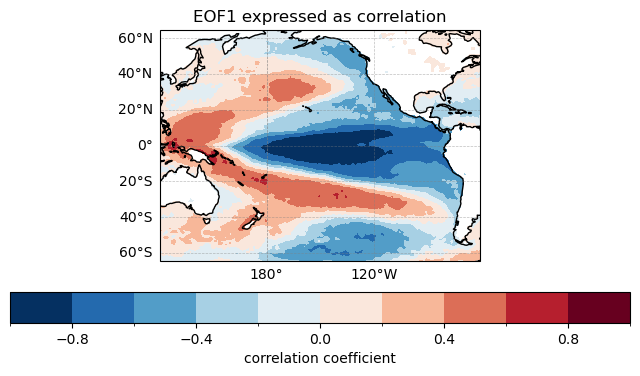

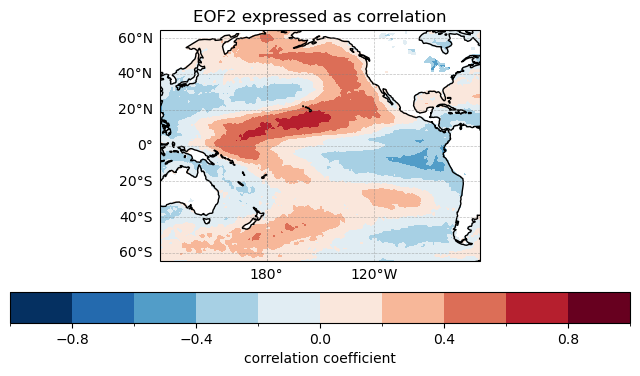

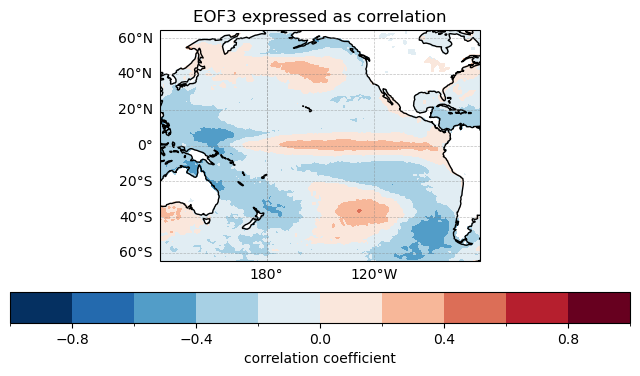

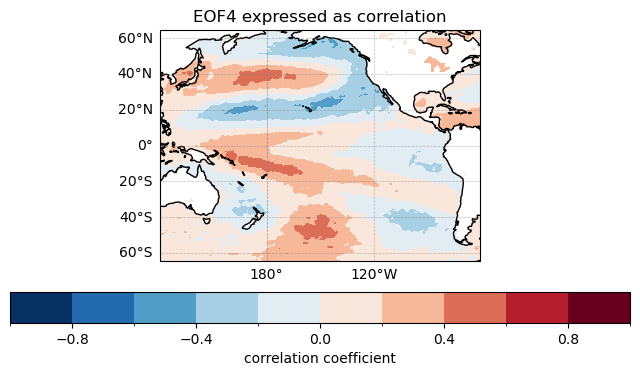

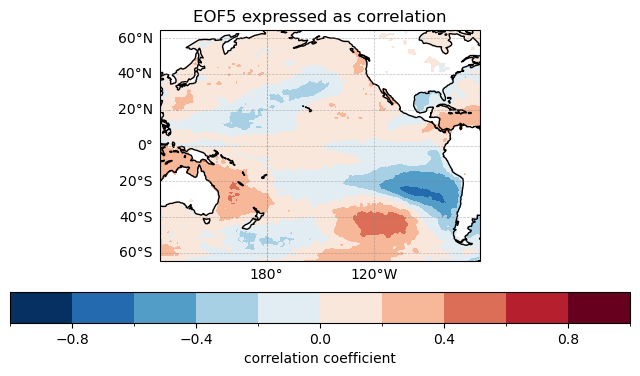

In [32]:
# --- Plot first 5 EOFs as correlation maps (keeps plotting style) ---
clevs = np.linspace(-1, 1, 11)
for i in range(5):
    fig, ax = plt.subplots(figsize=(8,4), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=190)))
    fill = eofs_corr[i].plot.contourf(
        ax=ax, levels=clevs, cmap=plt.cm.RdBu_r, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    cb = plt.colorbar(fill, orientation='horizontal', pad=0.1)
    cb.set_label('correlation coefficient', fontsize=10)
    ax.set_title(f'EOF{i+1} expressed as correlation', fontsize=12)

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Latitude (°N)')

plt.show()

## Step 12. Plot variance fraction
Visualize the fraction of variance explained by the first 10 EOFs as a bar chart with percent values on top of each bar.

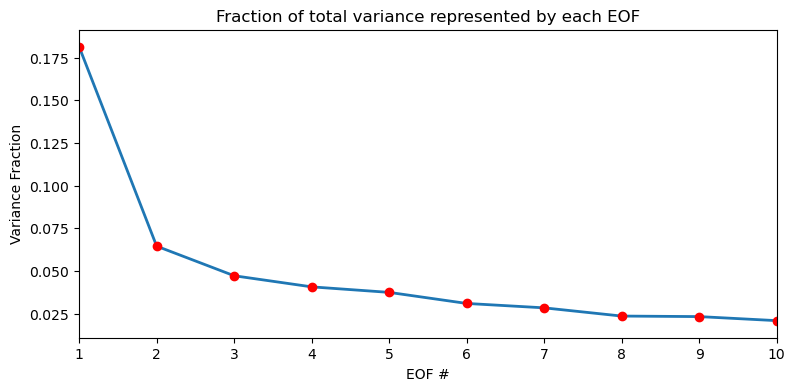

In [ ]:
# --- Plot fraction of variance explained by first 10 EOFs ---
plt.figure(figsize=(9,4))
eof_num = np.arange(1, neofs+1)
plt.plot(eof_num, varfrac_arr[:neofs], linewidth=2)
plt.plot(eof_num, varfrac_arr[:neofs], linestyle='None', marker="o", color='r', markersize=6)
plt.axhline(0, color='k')
plt.xticks(range(1, neofs+1))
plt.title('Fraction of total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, neofs)
plt.ylim(np.min(varfrac_arr[:neofs]) - 0.01, np.max(varfrac_arr[:neofs]) + 0.01)
plt.show()

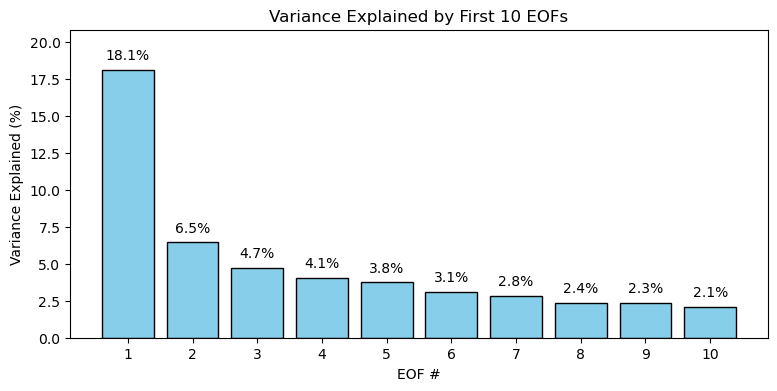

In [ ]:
# --- Plot percent of variance explained by first 10 EOFs ---
plt.figure(figsize=(9,4))
eof_percent = varfrac_arr[:neofs] * 100  # convert to percent
bars = plt.bar(np.arange(1, neofs+1), eof_percent, color='skyblue', edgecolor='k')
plt.xticks(range(1, neofs+1))
plt.ylabel('Variance Explained (%)')
plt.xlabel('EOF #')
plt.title('Variance Explained by First 10 EOFs')

# Annotate percent on top of each bar
for bar, percent in zip(bars, eof_percent):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{percent:.1f}%', ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(eof_percent)*1.15)
plt.show()

## Step 13. Reconstruct SST field using first 5 EOFs
Reconstruct SST using leading EOFs and compare with observed SST. Compute and plot the Pearson correlation map.

In [ ]:
# --- Reconstruct SST field using first 5 EOFs and compute Pearson correlation map ---
n_reconstruct = 5
print(f"\nReconstructing SST using first {n_reconstruct} EOFs...")

# --- Reconstruct SST field using leading EOFs ---
reconstruction = solver.reconstructedField(n_reconstruct)   # dims (time, latitude, longitude)
print("Reconstruction dims:", reconstruction.dims)

# --- Harmonize time dimension names ---
# --- The EOF solver uses "time", but sst_anom uses "valid_time" ---
if "valid_time" in sst_anom.dims and "time" in reconstruction.dims:
    reconstruction = reconstruction.rename(time="valid_time")

# --- Align datasets to ensure same coordinates ---
sst_anom, reconstruction = xr.align(sst_anom, reconstruction)

print("Computing Pearson correlation between reconstruction and observed sst_anom...")

# --- Compute correlation across time at each grid cell ---
corr_map = xr.corr(sst_anom, reconstruction, dim="valid_time")

print("Final correlation map dims:", corr_map.dims)
print("Sample correlation range:", float(corr_map.min()), "to", float(corr_map.max()))


Reconstructing SST using first 5 EOFs...
Reconstruction dims: ('time', 'latitude', 'longitude')


Computing Pearson correlation between reconstruction and observed sst_anom...
Final correlation map dims: ('latitude', 'longitude')
Sample correlation range: 0.045197680592536926 to 0.9293314218521118


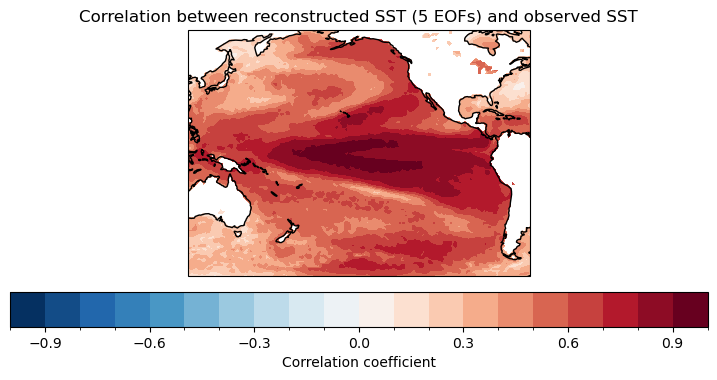

In [18]:
fig, ax = plt.subplots(figsize=(9,4), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=190)))
fill = corr_map.plot.contourf(ax=ax, levels=np.linspace(-1, 1, 21), cmap=plt.cm.RdBu_r,
                              add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(fill, orientation='horizontal', pad=0.05)
cb.set_label('Correlation coefficient')
ax.set_title('Correlation between reconstructed SST (5 EOFs) and observed SST')
plt.show()

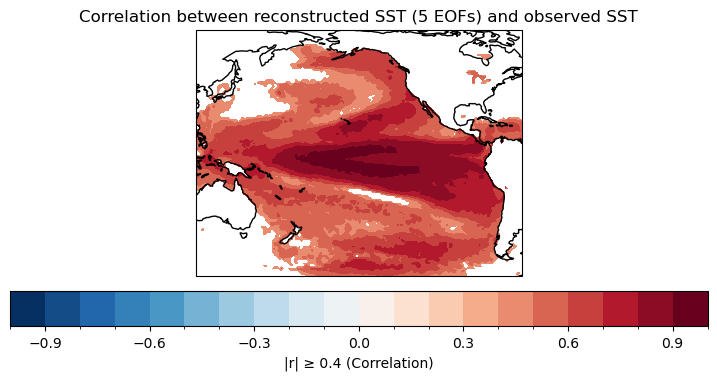

In [ ]:
# --- Mask correlations below 0.4 (for visual clarity) - Optional ---
masked_corr = corr_map.where(abs(corr_map) >= 0.4)

fig, ax = plt.subplots(figsize=(9, 4),
                       subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=190)))
fill = masked_corr.plot.contourf(
    ax=ax,
    levels=np.linspace(-1, 1, 21),
    cmap=plt.cm.RdBu_r,
    add_colorbar=False,
    transform=ccrs.PlateCarree()
)
ax.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(fill, orientation='horizontal', pad=0.05)
cb.set_label('|r| ≥ 0.4 (Correlation)')
ax.set_title('Correlation between reconstructed SST (5 EOFs) and observed SST')
plt.show()

## Step 14. Correlation between SST EOF1 (PC1) and TCRW anomalies
Compute Pearson correlation between the first SST EOF's PC1 and TCRW anomalies, plotting a map of correlation coefficients.

In [ ]:
# --- Compute correlation between SST EOF1 (PC1 time series) and TCRW anomalies ---
print("\nComputing correlation between PC1 and TCRW anomalies (no land mask for plot as requested)...")

# --- Select first principal component (PC1) ---
try:
    pc1 = pcs.sel(mode=0)
except Exception:
    # fallback if mode index is integer-positioned
    pc1 = pcs.isel(mode=0) if "mode" in pcs.dims else pcs[:, 0]
print("pc1 dims:", pc1.dims)


Computing correlation between PC1 and TCRW anomalies (no land mask for plot as requested)...
pc1 dims: ('time',)


In [ ]:
# --- Recompute TCRW anomalies without ocean mask ---
tcrw_unmasked = ds1deg["tcrw"]
time_dim = "valid_time"
tcrw_unmasked_detr = linear_detrend(tcrw_unmasked.to_dataset(name="tcrw"), time_dim=time_dim)["tcrw"]
tcrw_unmasked_anom = monthly_anom_and_z(tcrw_unmasked_detr, time_dim=time_dim, 
                                        base_period=("1981-01-01", "2010-12-31"))[1]

# --- Make PC1 a DataArray with matching coordinate ---
pc1_da = xr.DataArray(pc1, coords=[tcrw_unmasked_anom.valid_time], dims=["valid_time"])

# --- Compute correlation along valid_time ---
corr_tcrw = xr.corr(tcrw_unmasked_anom, pc1_da, dim="valid_time")

print("corr_tcrw dims:", corr_tcrw.dims)

corr_tcrw dims: ('latitude', 'longitude')


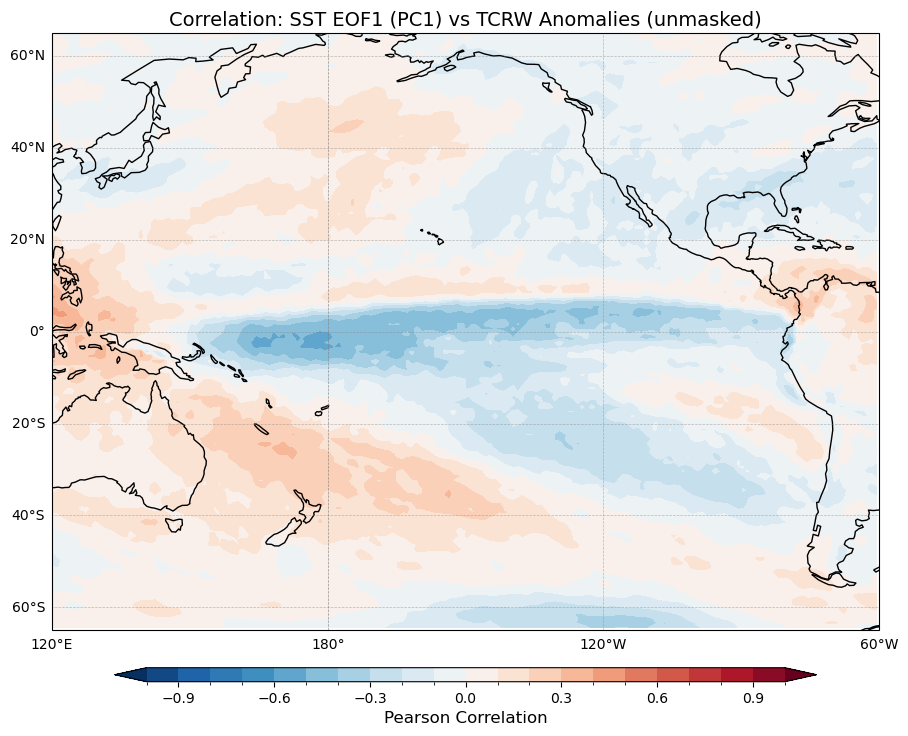


All steps complete. Files produced:
 - saved dataset: era5_pacific_sst_tcrw_1deg_1979_2024.nc
Key objects in memory: ds (coarsened & masked), detr (detrended), anom, z, sst_anom, tcrw_anom, sst_std, solver, pcs, reconstruction


In [ ]:
# --- Plot correlation map ---
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
cf = corr_tcrw.plot.contourf(
    ax=ax, levels=np.linspace(-1, 1, 21), cmap="RdBu_r", extend="both",
    add_colorbar=False, transform=ccrs.PlateCarree()
)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50, shrink=0.6)
cbar.set_label('Pearson Correlation', fontsize=12)
plt.title("Correlation: SST EOF1 (PC1) vs TCRW Anomalies (unmasked)", fontsize=14)
plt.tight_layout()
plt.show()

print("\nAll steps complete. Files produced:")
print(f" - saved dataset: {out_fname}")
print("Key objects in memory: ds (coarsened & masked), detr (detrended), anom, z, "
      "sst_anom, tcrw_anom, sst_std, solver, pcs, reconstruction")